<a href="https://colab.research.google.com/github/sriharikunchala/Todo/blob/main/stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import requests
from bs4 import BeautifulSoup
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# ------------------ Technical indicators ------------------
def build_ta_features(df):
    df['MA20'] = ta.trend.sma_indicator(df['Close'], 20)
    df['MA50'] = ta.trend.sma_indicator(df['Close'], 50)
    df['RSI'] = ta.momentum.rsi(df['Close'], 14)

    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_SIGNAL'] = macd.macd_signal()
    df['MACD_HIST'] = macd.macd_diff()

    df['ATR'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'])
    df['RET'] = df['Close'].pct_change()

    df = df.dropna()
    return df

# ------------------ News Sentiment ------------------
def fetch_news_sentiment(ticker):
    url = f"https://www.moneycontrol.com/financials/{ticker}/news/"
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")
        headlines = [h.get_text() for h in soup.find_all("a") if len(h.get_text()) > 20][:10]
    except:
        headlines = []

    analyzer = SentimentIntensityAnalyzer()
    if not headlines:
        return 0.0  # neutral if no news
    scores = [analyzer.polarity_scores(h)['compound'] for h in headlines]
    return np.mean(scores)  # average sentiment

# ------------------ LSTM Hybrid Model ------------------
def hybrid_stock_predict(ticker):
    print("Downloading historical data...")
    df = yf.download(ticker.upper()+".NS", period="5y")

    # Flatten multiindex columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df = df[['Open','High','Low','Close','Volume']]
    df = build_ta_features(df)

    # 7-day future price target
    for i in range(1, 8):
        df[f'future_close_{i}'] = df['Close'].shift(-i)
    df = df.dropna()

    features = ['Close','MA20','MA50','RSI','MACD','MACD_SIGNAL','MACD_HIST','ATR','Volume','RET']
    X_data = df[features].values
    scaler_x = MinMaxScaler()
    X_scaled = scaler_x.fit_transform(X_data)

    # Regression target (7 days)
    y_data = df[[f'future_close_{i}' for i in range(1,8)]].values
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y_data)

    # Create sequences for LSTM
    seq_len = 60
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X_scaled)):
        X_seq.append(X_scaled[i-seq_len:i])
        y_seq.append(y_scaled[i])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    # Train-test split
    split = int(0.8*len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    # ------------------ Build LSTM Regression ------------------
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.25),
        LSTM(64),
        Dropout(0.25),
        Dense(7)  # 7-day price prediction
    ])
    model.compile(optimizer='adam', loss='mse')
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1, callbacks=[es], verbose=1)

    # Predict next 7 days
    last_seq = X_seq[-1].reshape(1, seq_len, len(features))
    pred_scaled = model.predict(last_seq)
    predicted_prices = scaler_y.inverse_transform(pred_scaled)[0]

    # UP/DOWN probability for next day
    up_prob = max(0,min(100, 50 + ((predicted_prices[0]-df['Close'].iloc[-1])/df['Close'].iloc[-1]*100)*2))
    down_prob = 100 - up_prob

    # Sentiment score
    sentiment_score = fetch_news_sentiment(ticker)

    print("\n===== Hybrid LSTM Prediction =====")
    print(f"Next 7-day predicted prices: {predicted_prices}")
    print(f"Next day UP probability: {up_prob:.2f}% | DOWN probability: {down_prob:.2f}%")
    print(f"Current News Sentiment Score: {sentiment_score:.2f}")

    return {
        "7_day_prices": predicted_prices,
        "up_probability": up_prob,
        "down_probability": down_prob,
        "news_sentiment": sentiment_score
    }

# ------------------ RUN ------------------
ticker = input("Enter NSE ticker (e.g., PIIND, RELIANCE, TCS): ")
result = hybrid_stock_predict(ticker)
result


Enter NSE ticker (e.g., PIIND, RELIANCE, TCS): bandhanbnk


/tmp/ipython-input-3090108937.py:51: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker.upper()+".NS", period="5y")
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 0.1129 - val_loss: 0.0062
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0208 - val_loss: 0.0034
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0160 - val_loss: 0.0064
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0150 - val_loss: 0.0022
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0130 - val_loss: 0.0027
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0132 - val_loss: 0.0043
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0124 - val_loss: 0.0021
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0114 - val_loss: 0.0024
Epoch 9/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.0107 - val_loss: 0.0023
Epoch 10/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0102 - val_loss: 0.0029
Epoch 11/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0098 - val_loss: 0.0021
Epoch 12/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss:

{'7_day_prices': array([160.90602, 161.97975, 164.53664, 163.08597, 161.58731, 165.56775,
        161.71396], dtype=float32),
 'up_probability': np.float64(60.43095380157686),
 'down_probability': np.float64(39.56904619842314),
 'news_sentiment': np.float64(0.07096)}

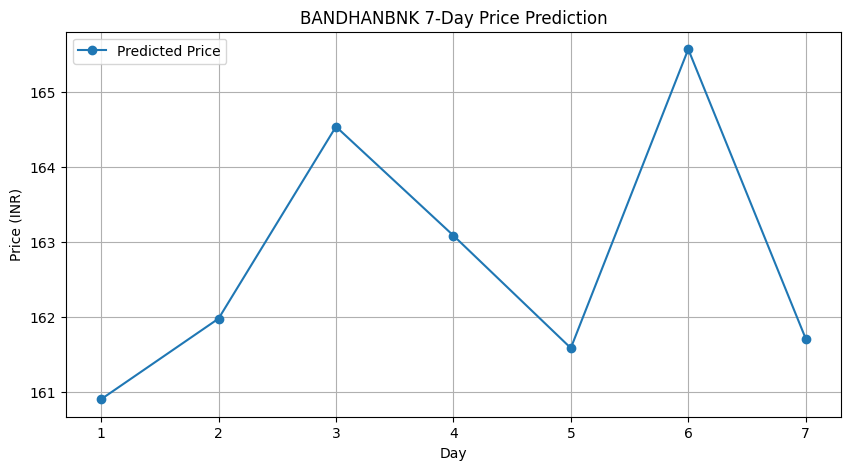

Next day UP probability: 60.43%
Next day DOWN probability: 39.57%
News Sentiment: 0.07


In [25]:
days = np.arange(1, 8)
plt.figure(figsize=(10,5))
plt.plot(days, result['7_day_prices'], marker='o', label='Predicted Price')
plt.title(f"{ticker.upper()} 7-Day Price Prediction")
plt.xlabel("Day")
plt.ylabel("Price (INR)")
plt.grid(True)
plt.legend()
plt.show()

print(f"Next day UP probability: {result['up_probability']:.2f}%")
print(f"Next day DOWN probability: {result['down_probability']:.2f}%")
print(f"News Sentiment: {result['news_sentiment']:.2f}")
